# Challenge: model comparison

You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
PATH = r'C:\Users\latee\Downloads\etsy-shops\etsy_shops_data.csv'
esty = pd.read_csv(PATH)

In [3]:
# dataset column key
esty_key = pd.DataFrame(['The date that the shop has been created in Etsy website.',
                        'The number of active listing this shop has at the moment of capturing the data.',
                        'Number of people who follow this shop.',
                        "The ISO currency code for the seller's native currency.",
                        'Is this shop USA based?',
                        'Does this shop have a sale message (message send to buyer upon a purchase)?',
                        'Number of sales that the shop has made.',
                        'Number of reviews that the shop has gained',
                        'The location of the site (country, city)'])
esty_key.index = esty.columns.unique()

In [4]:
esty_key

,0
creation_date,The date that the shop has been created in Ets...
listing_active_count,The number of active listing this shop has at ...
num_favorers,Number of people who follow this shop.
currency_code,The ISO currency code for the seller's native ...
is_shop_us_based,Is this shop USA based?
sale_message,Does this shop have a sale message (message se...
sales_count,Number of sales that the shop has made.
review_count,Number of reviews that the shop has gained
shop_location,"The location of the site (country, city)"


### I am not interested in all of these features

I am interested in:

    * num_favorers
    * sale_message
    * review_count
    * sales_count

I am not interested in:

    * creation date
    * listing_active_count - bcuz the time of day that the data was collected may affect the values observed
    * a non US based currency
    * Non US shops
    * Shop location
    
    
Note: Each observation is a diferent shop.

In [5]:
esty.head()

,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0,0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2,0,None
2,19-Nov,0,0,USD,True,False,-99,-99,None
3,19-Nov,40,1,USD,False,False,0,0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0,0,"New York, United States"


In [6]:
esty1 = esty[esty.is_shop_us_based != False]

In [7]:
esty1 = esty.drop(['creation_date', 'currency_code', 'is_shop_us_based', 'shop_location'], axis=1)

In [8]:
numeric_columns = esty1.select_dtypes(['int64', 'float64']).columns
non_numeric_columns = esty1.select_dtypes(['object']).columns

In [9]:
esty1.head()

,listing_active_count,num_favorers,sale_message,sales_count,review_count
0,3,1,False,0,0
1,13,1,False,2,0
2,0,0,False,-99,-99
3,40,1,False,0,0
4,7,1,False,0,0


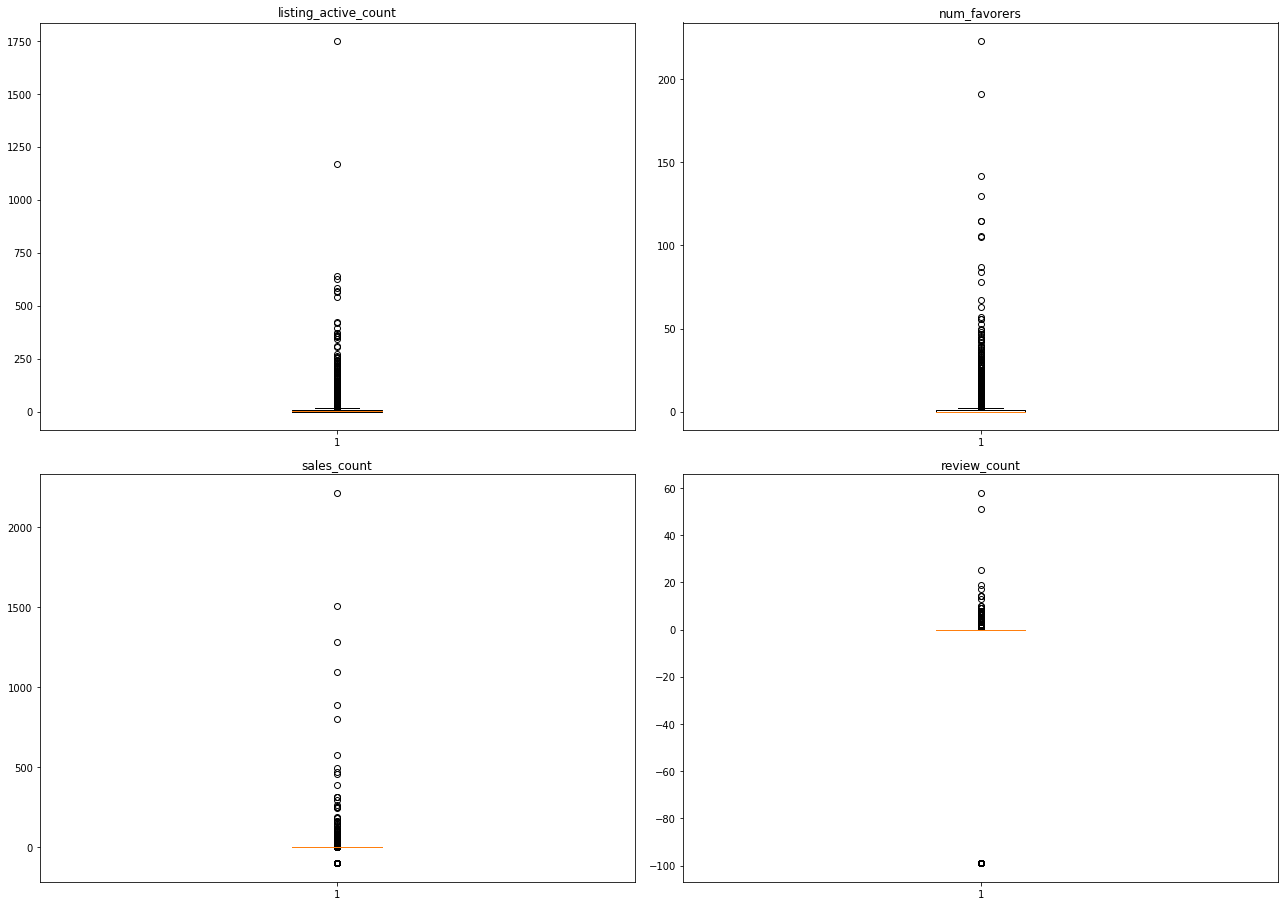

In [10]:
plt.figure(figsize=(18, 25))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, i+1)
    plt.boxplot(x=col, data=esty1, whis=1.5)
    plt.title(col)
    
plt.tight_layout()

I cannot rationalized why or how a negative number of reviews was recorded, but I will drop them. 

In [11]:
esty1.loc[esty1.review_count < 1, 'review_count'] = 0

### It appears negative values are possible with etsy, due to their billing system. 

I found this online.

When you sell on Etsy, you'll incur fees for using Etsy.com. If you make any sales through Etsy Payments, your fees will automatically be deducted. If your current balance is negative at the end of the month, you'll have an amount due on the first on the next month.

It's abundantly clear that all of our distributions are skewed to the right. 

My assumption is that some of the shops are far more popular than the rest. I need to limit their affects on the data to avoid problems later, winsorization should help a bit. 

In [12]:
from scipy.stats.mstats import winsorize

esty_win = esty1.copy()

for col in esty_win.columns:
    esty_win[col] = winsorize(esty_win[col], (.0, .001))

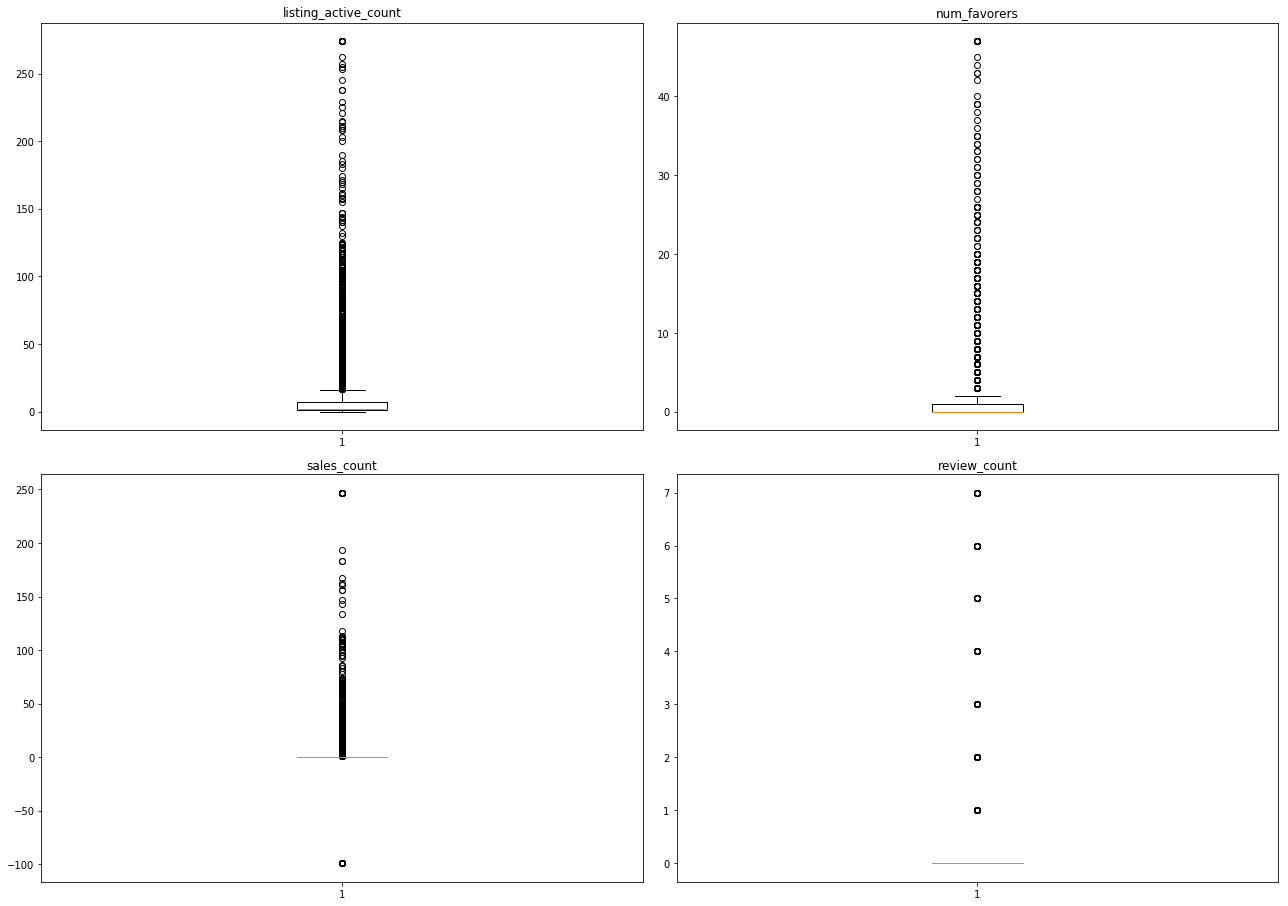

In [13]:
plt.figure(figsize=(18, 25))
plt.subplots_adjust(hspace=1, wspace=1)
for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, i+1)
    plt.boxplot(x=col, data=esty_win, whis=1.5)
    plt.title(col)
    
plt.tight_layout()

In [14]:
esty_win.head()

,listing_active_count,num_favorers,sale_message,sales_count,review_count
0,3,1,False,0,0
1,13,1,False,2,0
2,0,0,False,-99,0
3,40,1,False,0,0
4,7,1,False,0,0


This is the best I could do without losing too much information.  

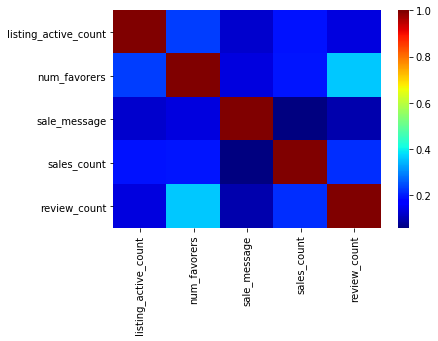

In [15]:
sns.heatmap(esty_win.corr(), cmap='jet')

### Preprocessing

In [16]:
esty_win['sale_message'] = esty_win['sale_message'].astype(int)

In [17]:
esty_win.tail()

,listing_active_count,num_favorers,sale_message,sales_count,review_count
19995,3,2,0,0,0
19996,1,0,0,0,0
19997,1,0,0,0,0
19998,1,0,0,0,0
19999,1,0,0,1,0


### Modeling

In [18]:
# Dataframe to hold errors
err_chart = pd.DataFrame(index=['R-squared of training', 'R-squared of test',
                                'Mean absolute error', 'Mean squared error', 'Root mean squared error',
                                'Mean absolute percentage error'])

In [19]:
# selecting the "data" and "target"
X = esty_win[['listing_active_count', 'num_favorers', 'review_count']]
y = esty_win[['sales_count']]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.73)

# you are fitting PCA on the training set only
pca.fit(X_train)
print('Optimal Components: ', pca.n_components_)

Optimal Components:  2


C:\Users\latee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\latee\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\latee\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [20]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# create model instance
lrm = LinearRegression()

# adding constant and fitting
X_train = sm.add_constant(X_train)

# fit the model to the training data (learning coefficients)
lrm.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# Making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

err_chart['OLS'] = list([lrm.score(X_train, y_train), lrm.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [21]:
err_chart

,OLS
R-squared of training,0.0825367
R-squared of test,0.0813123
Mean absolute error,14.9664
Mean squared error,[752.0639034823676]
Root mean squared error,[27.423783536966003]
Mean absolute percentage error,sales_count inf dtype: float64


In [22]:
score = cross_val_score(lrm, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.08 (+/- 0.06)


In [23]:
esty.corr()

,listing_active_count,num_favorers,is_shop_us_based,sale_message,sales_count,review_count
listing_active_count,1.000000,0.128962,-0.027260,0.088884,0.129562,0.088258
num_favorers,0.128962,1.000000,0.056522,0.108650,0.208715,0.042248
is_shop_us_based,-0.027260,0.056522,1.000000,0.031283,-0.041897,-0.073684
sale_message,0.088884,0.108650,0.031283,1.000000,0.046958,0.040816
sales_count,0.129562,0.208715,-0.041897,0.046958,1.000000,0.720403
review_count,0.088258,0.042248,-0.073684,0.040816,0.720403,1.000000


This performed terribly, it's not overfitting - it's just bad. Our features do not appear to explain much about our target, but for the sake of the exercise let's see which one performs better. 

# KNN

In [24]:
# selecting the "data" and "target"
X = esty_win[['listing_active_count', 'num_favorers', 'review_count']]
y = esty_win[['sales_count']]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=40)

# scalar obj
scaler = StandardScaler()

# Fitting on training
scaler.fit(X_train)

# Apply transform to both the training 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create an instance for the pca (feature reduction algorithm)
pca = PCA(.88)

# you are fitting PCA on the training set only
pca.fit(X_train)
print('Optimal Components: ', pca.n_components_)

C:\Users\latee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Optimal Components:  3


C:\Users\latee\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\Users\latee\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [25]:
# Apply the mapping (transform) to both the training set and the test set.
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# create model instance
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

# adding constant and fitting
X_train = sm.add_constant(X_train)

# fit the model to the training data (learning coefficients)
knn.fit(X_train, y_train)

# Adding a constant Best Practice!
X_test = sm.add_constant(X_test)

# Making predictions here
y_preds_train = knn.predict(X_train)
y_preds_test = knn.predict(X_test)

err_chart['KNN'] = list([knn.score(X_train, y_train), knn.score(X_test, y_test),
                          mean_absolute_error(y_test, y_preds_test),
                          mse(y_test, y_preds_test), rmse(y_test, y_preds_test),
                          np.mean(np.abs((y_test - y_preds_test) / y_test) * 100)])

In [26]:
err_chart

,OLS,KNN
R-squared of training,0.0825367,0.487243
R-squared of test,0.0813123,0.498731
Mean absolute error,14.9664,8.6331
Mean squared error,[752.0639034823676],[410.35271]
Root mean squared error,[27.423783536966003],[20.257164411634715]
Mean absolute percentage error,sales_count inf dtype: float64,sales_count inf dtype: float64


In [27]:
score = cross_val_score(knn, X, y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.44 (+/- 0.08)


Neither one of these models did a good job of predicting our target. The KNN regression model performed better, but still not good. Both do a terrible job of making predictions, but it appears that the problem isn't with the models choosen, but data used. It presents a lot of problems like low feature to target correlation and outliers.  